In [223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from sklearn.linear_model import LogisticRegression as LR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
import json

In [225]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale, get_openai_prompts, get_val_set, find_temp_scale_with_q, get_text_probs, sample_quantile, draw_reliability_graph, get_test_set

In [226]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [308]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'
num_classes = 10

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [309]:
t = templates[1]
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
ECE, _, acc = get_metrics(predictions, actual, probs)
bins, _, bin_accs, _, bin_sizes = calc_bins(predictions, actual, probs)

scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
predictions, actual, probs_scaled = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
ECE_scaled, _, acc_scaled = get_metrics(predictions, actual, probs_scaled)
bins_scaled, _, bin_accs_scaled, _, bin_sizes_scaled = calc_bins(predictions, actual, probs_scaled)

In [276]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR100'
num_classes = 100

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)

predictions, actual, probs_cifar100 = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
ECE_cifar100, _, acc = get_metrics(predictions, actual, probs_cifar100)
bins_cifar100, _, bin_accs_cifar100, _, bin_sizes_cifar100 = calc_bins(predictions, actual, probs_cifar100)

scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
predictions, actual, probs_scaled_cifar100 = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
ECE_scaled_cifar100, _, acc_scaled = get_metrics(predictions, actual, probs_scaled_cifar100)
bins_scaled_cifar100, _, bin_accs_scaled_cifar100, _, bin_sizes_scaled_cifar100 = calc_bins(predictions, actual, probs_scaled_cifar100)

Files already downloaded and verified
Files already downloaded and verified


Text(0.5, 0.98, 'Reliability Diagram - Before Calibration')

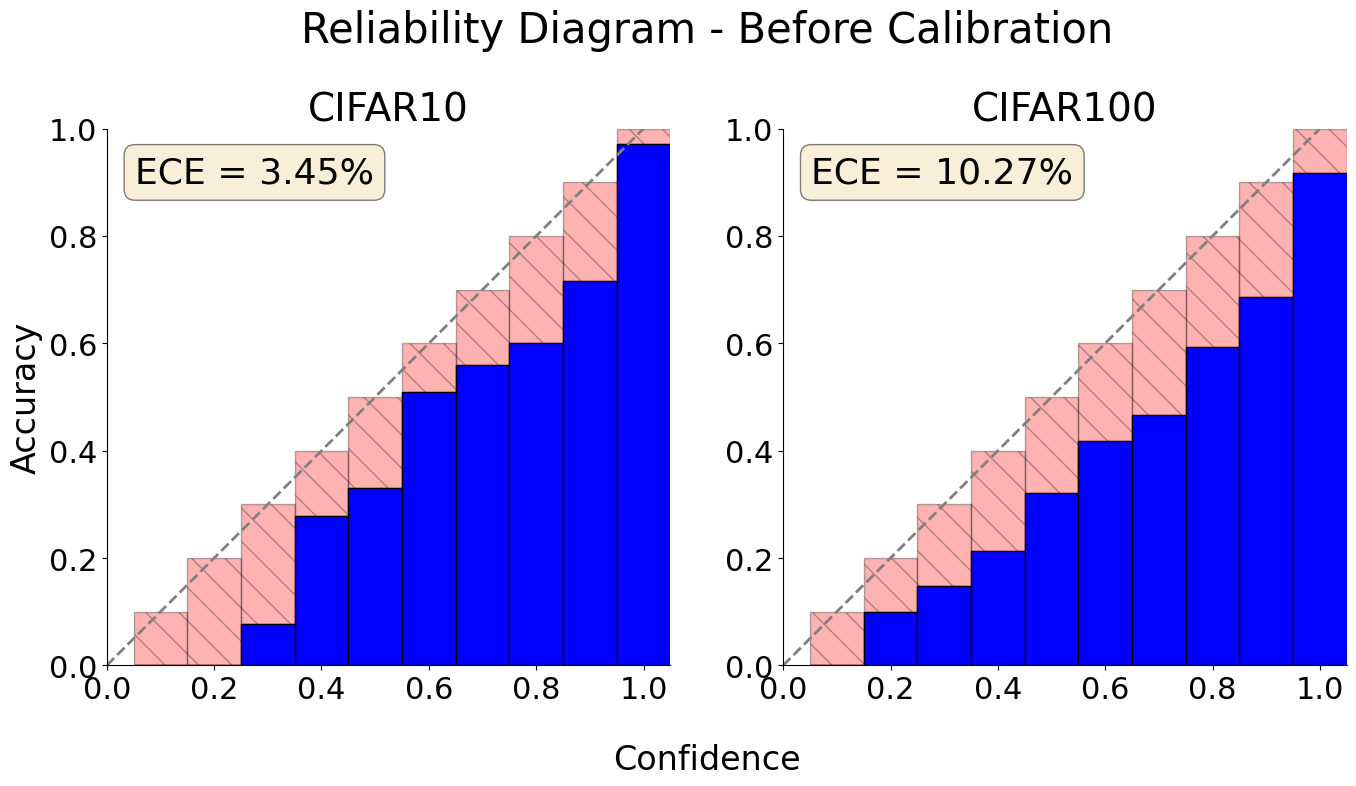

In [71]:
fig, axarr = plt.subplots(1,2, figsize=(16, 8))
for i in range(2):#ax in axarr:
    ax = axarr[i]

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    #ax.set_xlabel('Confidence', fontsize=24)
    #ax.set_ylabel('Accuracy', fontsize=24)
    
    # Create grid
    #ax.set_axisbelow(True) 
    #ax.grid(color='gray', linestyle='dashed')

    # Error bars
    ax.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    ax.plot([0,1],[0,1], '--', color='gray', linewidth=2)
    ax.set_aspect('equal', adjustable='box')
    ax.spines[['right', 'top']].set_visible(False)

axarr[0].set_ylabel('Accuracy', fontsize=24)

# Draw bars and identity line
axarr[0].bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins, np.minimum(bins, bin_accs), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(-1.15, 0.95, 'ECE = {:.2f}%'.format(ECE*100), transform=ax.transAxes, fontsize=26,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Draw bars and identity line
axarr[1].bar(bins_cifar100, bin_accs_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_cifar100, np.minimum(bins_cifar100, bin_accs_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[1].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE_cifar100*100), transform=ax.transAxes, fontsize=26,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axarr[0].set_title('CIFAR10', fontsize=28)
axarr[1].set_title('CIFAR100', fontsize=28)

fig.text(0.5,0.03, 'Confidence', ha='center', fontsize=24)

for ax in axarr:
    plt.sca(ax)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    
plt.suptitle('Reliability Diagram - Before Calibration', fontsize=30)#,  y = 1.01)
#plt.tight_layout()

Text(-1.04, 0.25, 'Sample frac.')

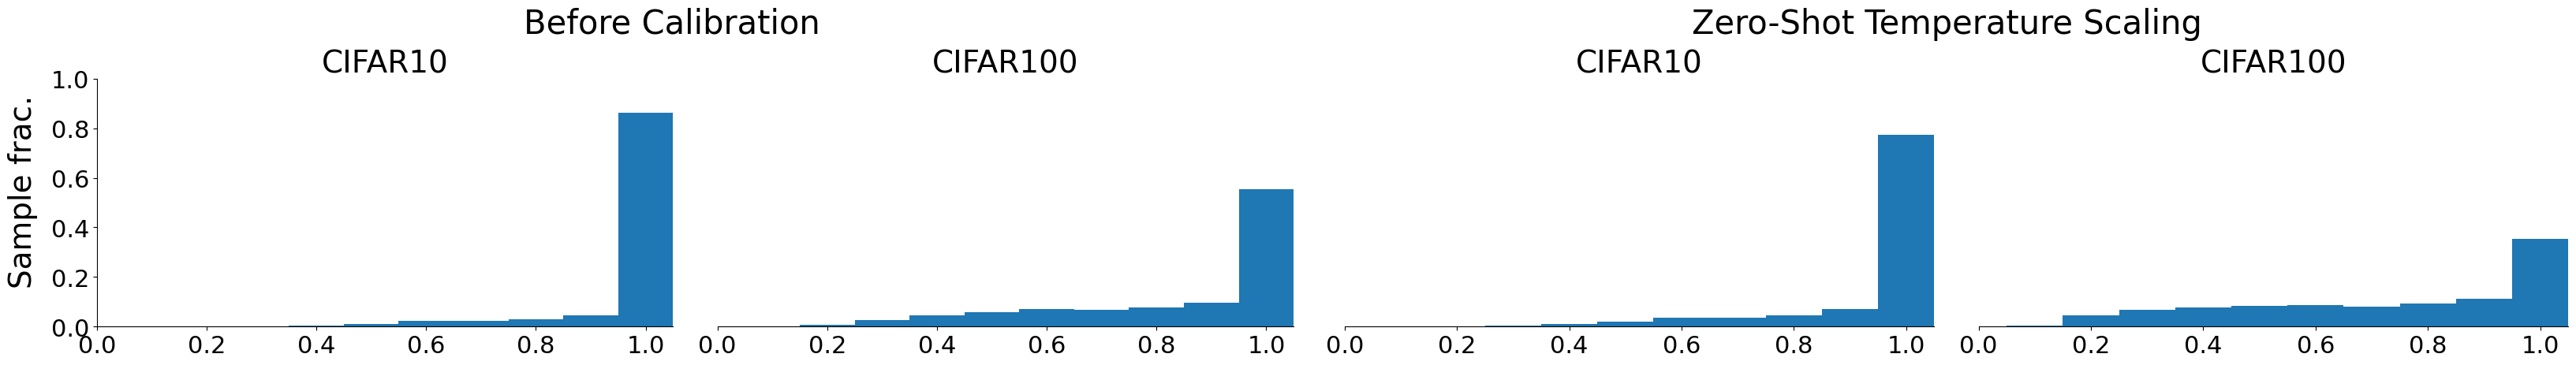

In [335]:
# Plot histogram confidences
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22) 
fig = plt.figure( constrained_layout=True, figsize=(32,4))
#fig.suptitle('Reliability Diagram', fontsize=32)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=1, ncols=2)
names = {
    0 : 'Before Calibration',
    1 : 'Zero-Shot Temperature Scaling'
}

for row, subfig in enumerate(subfigs):
    subfig.suptitle(names[row], fontsize=30, y=1.12)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        #if row == 0:
        if col == 0:
                ax.set_title('CIFAR10', fontsize=28)
        else:
                ax.set_title('CIFAR100', fontsize=28)
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1)
        #ax.axes.get_xaxis().set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        if not (row ==0 and col == 0):
                ax.axes.get_yaxis().set_visible(False)
                ax.spines[['left']].set_visible(False)

#x,_, p = plt.hist()
#for item in p:
#    item.set_height(item.get_height()/sum(x))
#plt.ylim([0,1.0])

xbins = np.insert(bins, 0, 0.0)


# Before Calibration
axarr = subfigs[0].get_axes()
for i, pr in enumerate([probs, probs_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  

# Scaled
axarr = subfigs[1].get_axes()
for i, pr in enumerate([probs_scaled, probs_scaled_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  

# Before Calibration
# CIFAR10


#axarr[0].bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='red', color='purple')
#axarr[0].bar(bins, np.minimum(bins, bin_accs), width=0.1, alpha=1, edgecolor='black', color='b')


# CIFAR100
#axarr[1].hist(probs_cifar100, xbins, density=True)
#axarr[1].bar(bins_cifar100, bin_accs_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
#axarr[1].bar(bins_cifar100, np.minimum(bins_cifar100, bin_accs_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')
        
# Scaled CIFAR10
#axarr = subfigs[1].get_axes()
#axarr[0].hist(probs_scaled, xbins, density=True)
#axarr[0].bar(bins_scaled, bin_accs_scaled, width=0.1, alpha=0.7, edgecolor='red', color='purple')
#axarr[0].bar(bins_scaled, np.minimum(bins_scaled, bin_accs_scaled), width=0.1, alpha=1, edgecolor='black', color='b')


# Scaled CIFAR100
#axarr[1].hist(probs_scaled_cifar100, xbins, density=True)
#axarr[1].bar(bins_scaled_cifar100, bin_accs_scaled_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
#axarr[1].bar(bins_scaled_cifar100, np.minimum(bins_scaled_cifar100,bin_accs_scaled_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')






#subfigs[-1].text(0,-0.08, 'Confidence', ha='center', fontsize=28)
subfigs[-1].text(-1.04,0.25, 'Sample frac.', ha='center', rotation=90, fontsize=28)

Text(-1.04, 0.37, 'Accuracy')

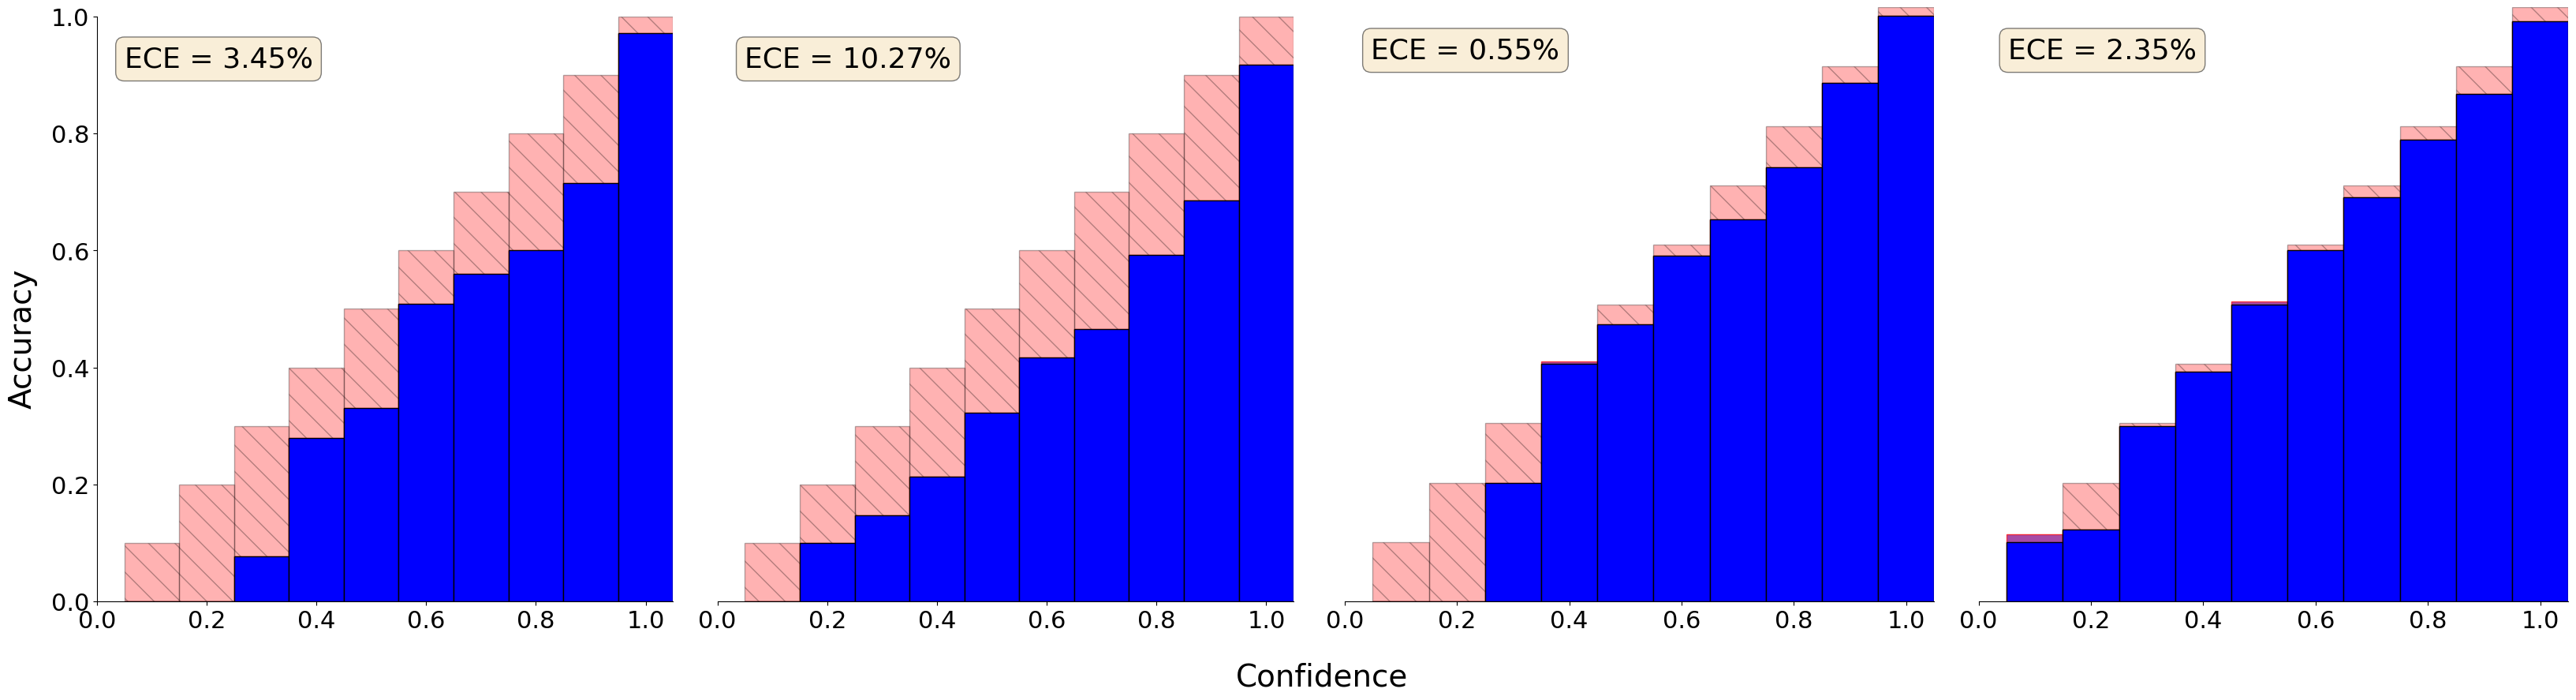

In [319]:
import matplotlib

matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22) 
fig = plt.figure( constrained_layout=True, figsize=(32,8))
#fig.suptitle('Reliability Diagram', fontsize=32)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=1, ncols=2)
names = {
    0 : 'Before Calibration',
    1 : 'Zero-Shot Temperature Scaling'
}

for row, subfig in enumerate(subfigs):
    #subfig.suptitle(names[row], fontsize=30, y=1.07)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        #if row == 0:
        #if col == 0:
        #        ax.set_title('CIFAR10', fontsize=28)
        #else:
        #        ax.set_title('CIFAR100', fontsize=28)
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1)
        ax.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

        #ax.plot([0,1],[0,1], '--', color='gray', linewidth=2)
        #ax.set_aspect('equal', adjustable='box')
        ax.spines[['right', 'top']].set_visible(False)
        if not (row ==0 and col == 0):
                ax.axes.get_yaxis().set_visible(False)
                ax.spines[['left']].set_visible(False)

# Before Calibration
# CIFAR10
axarr = subfigs[0].get_axes()
axarr[0].bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins, np.minimum(bins, bin_accs), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE*100),  fontsize=26,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# CIFAR100
axarr[1].bar(bins_cifar100, bin_accs_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_cifar100, np.minimum(bins_cifar100, bin_accs_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')
axarr[1].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE_cifar100*100), fontsize=26,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
# Scaled CIFAR10
axarr = subfigs[1].get_axes()
axarr[0].bar(bins_scaled, bin_accs_scaled, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins_scaled, np.minimum(bins_scaled, bin_accs_scaled), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(-1.03, 0.95, 'ECE = {:.2f}%'.format(ECE_scaled*100), transform=ax.transAxes, fontsize=26,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Scaled CIFAR100
axarr[1].bar(bins_scaled_cifar100, bin_accs_scaled_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_scaled_cifar100, np.minimum(bins_scaled_cifar100,bin_accs_scaled_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[1].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE_scaled_cifar100*100), transform=ax.transAxes, fontsize=26,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))





subfigs[-1].text(0,-0.08, 'Confidence', ha='center', fontsize=28)
subfigs[-1].text(-1.04,0.37, 'Accuracy', ha='center', rotation=90, fontsize=28)

In [18]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR100'
num_classes = 100

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)


eces_scaled = []
eces = []
accs_scaled = []
temps = []
for t in tqdm(templates[1:]):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    ece, _, acc = get_metrics(predictions, actual, probs)
    eces.append(ece)

    scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece, _, acc = get_metrics(predictions, actual, probs)
    eces_scaled.append(ece)
    temps.append(scaled_temp)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 18/18 [16:07<00:00, 53.73s/it]


In [19]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'
num_classes = 10

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)

eces_scaled_cifar10 = []
eces_cifar10 = []
accs_scaled_cifar10 = []
temps_cifar10 = []
for t in tqdm(templates[1:]):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    ece_cifar10, _, acc = get_metrics(predictions, actual, probs)
    eces_cifar10.append(ece_cifar10)

    scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece_cifar10, _, acc = get_metrics(predictions, actual, probs)
    eces_scaled_cifar10.append(ece_cifar10)
    temps_cifar10.append(scaled_temp)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 18/18 [15:45<00:00, 52.56s/it]


Text(0.5, -0.54, 'Prompt Template')

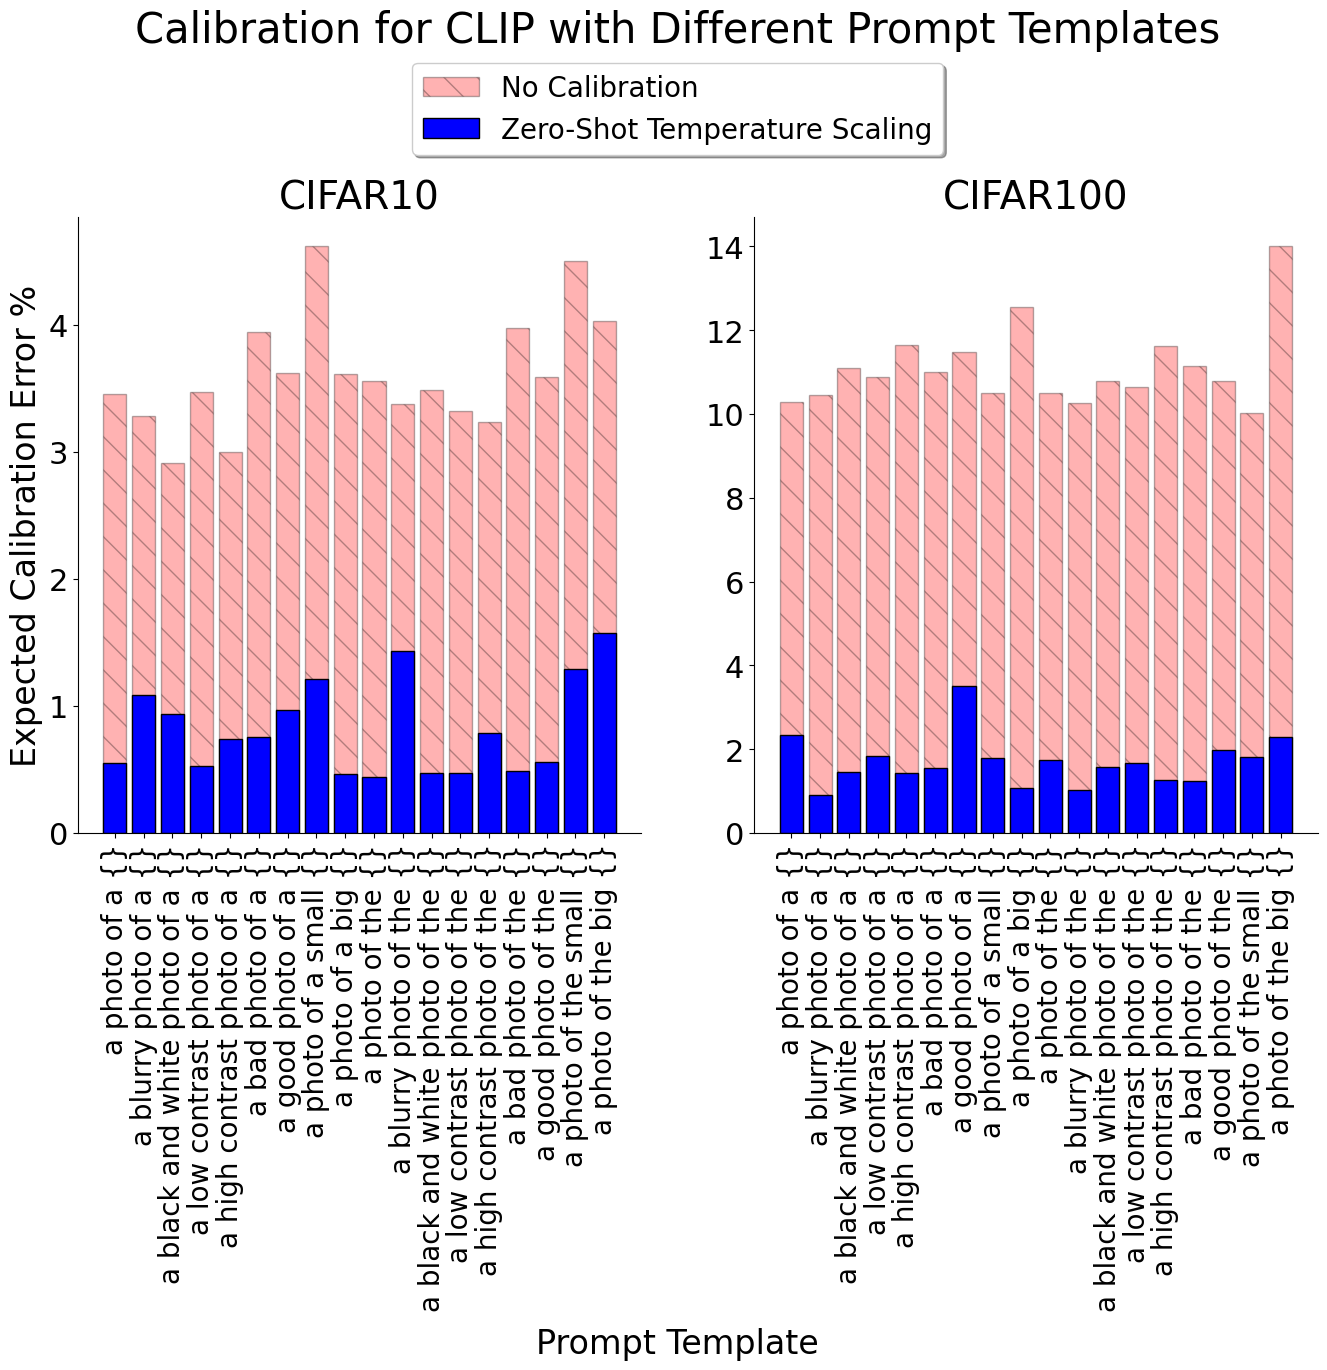

In [144]:
fig, axarr = plt.subplots(1,2, figsize=(16, 8))

for ax in axarr:
    # x/y labels
    #ax.set_xlabel('Prompt Template', fontsize=24)
    #ax.set_ylabel('Expected Calibration Error %', fontsize=24)

    # Create grid
    #ax.set_axisbelow(True) 
    #ax.grid(color='gray', linestyle='dashed')
    ax.spines[['right', 'top']].set_visible(False)

axarr[0].set_ylabel('Expected Calibration Error %', fontsize=24)
xaxis = [x[:-1] for x in templates[1:]]

axarr[0].bar(xaxis, np.array(eces_cifar10) * 100.0,  width=0.8, alpha=0.3, edgecolor='black', color='r', hatch='\\', label = 'No Calibration')
axarr[0].bar(xaxis, np.array(eces_scaled_cifar10) * 100.0, width=0.8, alpha=1, edgecolor='black', color='b', label = 'Zero-Shot Temperature Scaling')

axarr[1].bar(xaxis, np.array(eces) * 100.0,  width=0.8, alpha=0.3, edgecolor='black', color='r', hatch='\\', label = 'No Calibration')
axarr[1].bar(xaxis, np.array(eces_scaled) * 100.0, width=0.8, alpha=1, edgecolor='black', color='b', label = 'Zero-Shot Temperature Scaling')

axarr[0].set_title('CIFAR10', fontsize=28)
axarr[1].set_title('CIFAR100', fontsize=28)

#for ax in axarr:
    #ax.set_xticklabels(templates[1:], rotation=90, fontsize=14)
    #ax.set_yticklabels([txt.get_text() for txt in ax.get_yticklabels()],  fontsize=14)
    #ax.set_aspect('equal', adjustable='box')
handles, labels = axarr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, fontsize=20, bbox_to_anchor=(0.5, 1.09))
#axarr[0].legend(bbox_to_anchor=(0.45, 1.47), fancybox=True, shadow=True, loc='upper center')
# ECE and MCE legend
#ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
#MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
#acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
#plt.legend(handles=[ECE_patch, MCE_patch, acc_patch])
plt.suptitle('Calibration for CLIP with Different Prompt Templates', y = 1.14, fontsize=30)

for ax in axarr:
    plt.sca(ax)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=22)
    ax.xaxis.set_label_coords(0.5,-0.9)

fig.text(0.5, -0.54, 'Prompt Template', ha='center', fontsize=24)
#plt.tight_layout()


#plt.save_fig('plots/main_reliability.jpg')

Against Supervised Methods

In [190]:
def run_isotonic_OLD(labels_val, preds_val, probs_val, y_preds_proba_test):
    ir = IR( out_of_bounds = 'clip' )
    _, _, bin_accs_val, bin_confs_val, _ = calc_bins(labels_val, preds_val, probs_val)
    ir.fit( bin_confs_val, bin_accs_val )
    p_calibrated = ir.transform( y_preds_proba_test )
    return p_calibrated

In [205]:
def run_isotonic(labels_val, logits_val, logits_test):
    ir = IR( out_of_bounds = 'clip' )
    ir.fit( logits_val, labels_val )
    p_calibrated = ir.transform( logits_test )
    return p_calibrated

In [157]:
def run_decisiontree(y_true, preds, confs):
    dt = DT()
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)
    dt.fit( np.expand_dims(bin_confs,1), np.expand_dims(bin_accs,1) )
    p_calibrated = dt.predict( np.expand_dims(confs,1) )
    return p_calibrated

In [161]:
def run_plattscaling(y_true, preds, confs):
    lr = LR()  
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)
    lr.fit( np.expand_dims(bin_confs,1), np.expand_dims(bin_accs,1) )
    p_calibrated = lr.predict_proba( np.expand_dims(confs,1) )
    return p_calibrated

In [153]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

classes, templates = get_openai_prompts(dataset_name)
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [154]:
t = templates[1]
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
ECE, _, acc = get_metrics(predictions, actual, probs)
bins, _, bin_accs, _, _ = calc_bins(predictions, actual, probs)

scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
ECE_scaled, _, acc_scaled = get_metrics(predictions, actual, probs)
bins_scaled, _, bin_accs_scaled, _, _ = calc_bins(predictions, actual, probs)

In [192]:
y_preds_val, y_true_val, y_preds_proba_val = get_preds(model, tokenizer, val_dset, text_template=t)
run_isotonic(y_true_val, y_preds_proba_val, y_preds_val, probs)

array([0., 0., 0., ..., 0., 0., 0.])

In [206]:
logits_val = get_text_probs(
        model=model,
        tokenizer=tokenizer,
        dset=val_dset,
        text_template=t,
        batch_size=batch_size,
        device=device
    )
logits_test = get_text_probs(
        model=model,
        tokenizer=tokenizer,
        dset=cifar_test,
        text_template=t,
        batch_size=batch_size,
        device=device
    )
run_isotonic(y_preds_val, logits_val, logits_test)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [220]:
((y_probs_val, y_val), (y_probs_test, y_test)) = unpickle_probs('/home/ubuntu/resnet50_birds_logits.p')

In [222]:
ir = IR( out_of_bounds = 'clip' )
ir.fit( y_probs_val ,y_val.flatten())

ValueError: Isotonic regression input X should be a 1d array or 2d array with 1 feature

In [213]:
run_isotonic(np.expand_dims(y_preds_val,1), logits_val.cpu().numpy(), logits_test.cpu().numpy())

ValueError: Isotonic regression input X should be a 1d array or 2d array with 1 feature

In [209]:
type(y_preds_val)

numpy.ndarray

In [199]:
ir = IR( out_of_bounds = 'clip' )
_, _, bin_accs_val, bin_confs_val, _ = calc_bins(y_true_val, y_preds_val, y_preds_proba_val)
ir.fit( bin_confs_val, bin_accs_val )
iso_calib = ir.transform( probs )
get_metrics(actual, predictions, iso_calib)

(0.044106621794341744, 0.1755900723340381, 0.9176)

In [204]:
bin_confs_val, bin_accs_val

(array([0.        , 0.18868624, 0.2689478 , 0.36178763, 0.45687591,
        0.55001179, 0.65057521, 0.74840464, 0.8562991 , 0.99316786]),
 array([0.        , 0.        , 0.36363636, 0.24074074, 0.37588652,
        0.52398524, 0.592     , 0.63829787, 0.71358025, 0.97783222]))

In [162]:
ECE_ir,_,_ = get_metrics(actual, predictions, run_isotonic(actual, predictions, probs))
ECE_dt,_,_ = get_metrics(actual, predictions, run_decisiontree(actual, predictions, probs))
ECE_platt,_,_ = get_metrics(actual, predictions, run_plattscaling(actual, predictions, probs))

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

In [165]:
    lr = LR()  
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(actual, predictions, probs)
    lr.fit( np.expand_dims(bin_confs,1), np.expand_dims(bin_accs,1) )
    p_calibrated = lr.predict_proba( np.expand_dims(probs,1) )

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

## Main Table

##### Mean, std for different prompts in each entry. Entries for different datasets, architectures, pre-training data.